In [94]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from PIL import Image

%matplotlib inline

## Review

DBSCAN is a non-parametric clustering algorithm, meaning it does not make any assumptions about the shape of the clusters. This is great news for clusters that look like this:

<img src = "https://drive.google.com/uc?export=view&id=1oEgxzeR3ryvs-jp3OHv1jty6EgOs1wlz" alt="Q" style="width: 500px;"/>

It also introduces the concept of "Noise": data points that don't really fit into *any* cluster, like the smattering of points in database 3.

## Algo Review
In general, the algorithm is iterative, starting with a random core point, and finding all the **density connected/reachable** points from that **core point** and putting them into a cluster. Then it moves on to the next point.

<img src = "https://drive.google.com/uc?export=view&id=1XhHBpFnzgX2gx3vGT7LLNLCVXKbgqqY5" alt="Q" style="width: 300px;"/>

If a data point is **noise**, it marks it as such and moves on. This process repeats until all data points have been categorized.


<img src = "https://drive.google.com/uc?export=view&id=10ciqJpBrcnH7-Qdg2qokOHAIPbyub0p0" alt="Q" style="width: 500px;"/>


## `sklearn`


In [95]:
#### STEP 1. ####
df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KMEM5.csv")

predictors = ["x", "y"]


X = df[predictors]

#### STEP 2. ####
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

#### STEP 3. ####
db = DBSCAN(eps = 0.25, min_samples = 25)
pipe = Pipeline([("z", z), ("clust", db)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
X["clusters"] = labels

# X_clustered = X.loc[(X["clusters"] >= 0)]

print(silhouette_score(X[predictors], X["clusters"]))

print(ggplot(X, aes(x = "x", y = "y", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "DBSCAN Clustering Results for eps = 0.5, min_samples = 25",
         color = "Clusters"))

0.4447333252667154
<ggplot: (640 x 480)>


### the Elbow Methods for Eps

We're going to use the elbow method to find out what our neighborhood should be. We do that by looking at how far the $n^{th}$ neighbor for each data point is, and looking for an inflection point.

We'll use our trusty `NearestNeighbors()` for this.

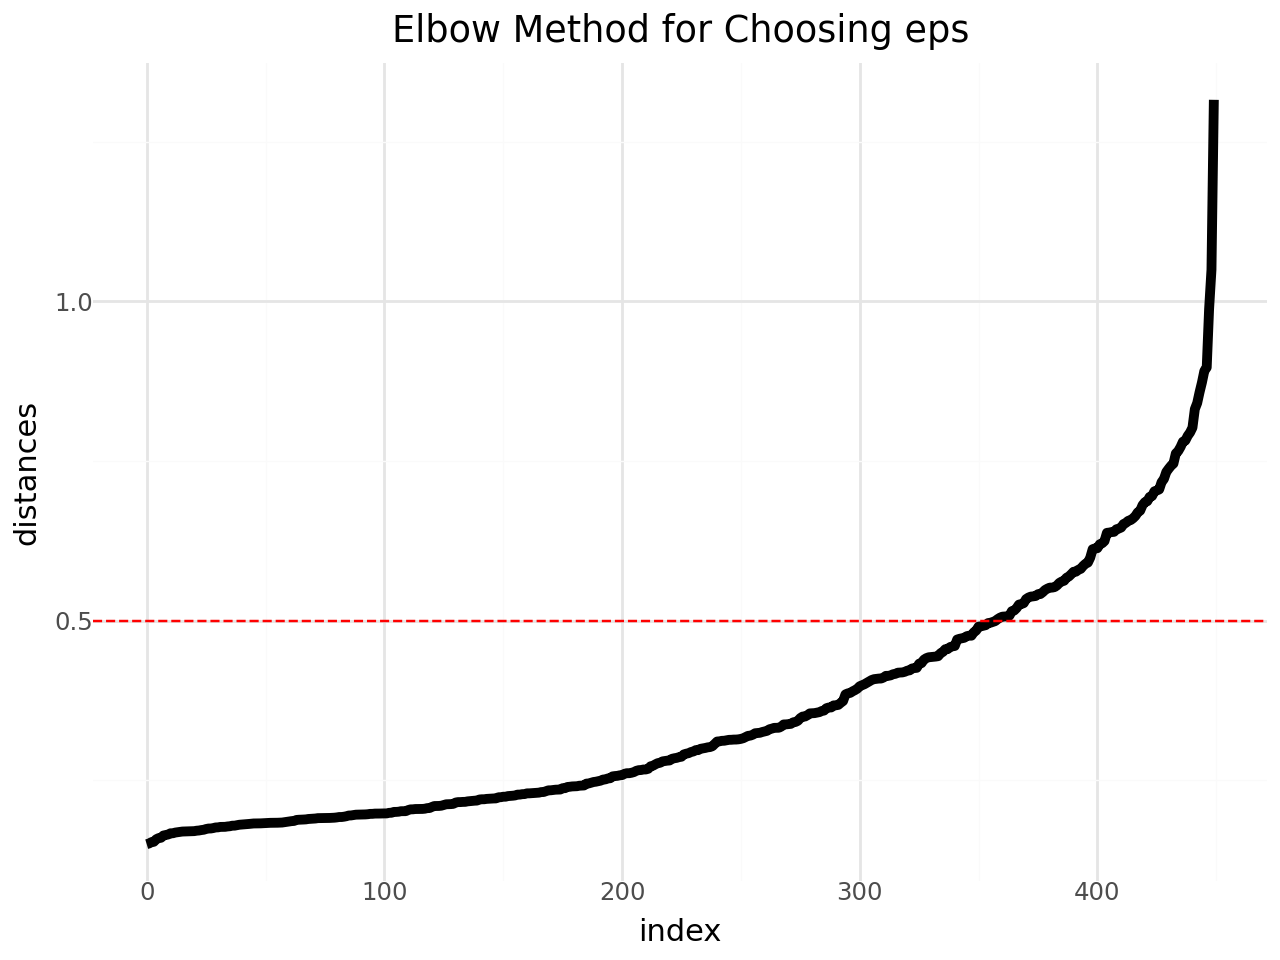

In [96]:
# we ask for mins + 1 nearest, because the data point it self (distance = 0) is included
mins = 25
nn = NearestNeighbors(n_neighbors = mins + 1)

# create pipeline (reusing z score object from above)
pipe_elbow = Pipeline([
    ("z", z),
    ("nn", nn)
])

# fit nn model
pipe_elbow.fit(X[predictors])

# get neighbors
distances, neighbors = pipe_elbow.named_steps["nn"].kneighbors(X[predictors])

# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
plt = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
       geom_hline(yintercept = 0.5, color = "red", linetype = "dashed") # our estimate for inflection point
       )

plt

In [97]:
#### STEP 3. ####
db = DBSCAN(eps = 0.5, min_samples = 25)
pipe = Pipeline([("z", z), ("clust", db)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
X["clusters"] = labels

# X_clustered = X.loc[(X["clusters"] >= 0)]

print(silhouette_score(X[predictors], X["clusters"]))

print(ggplot(X, aes(x = "x", y = "y", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "DBSCAN Clustering Results for eps = 0.5, min_samples = 25",
         color = "Clusters"))

0.5075126954762662
<ggplot: (640 x 480)>


## Another `sklearn` example

In [98]:
#### STEP 1. ####
df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KMEM4.csv")

predictors = ["x", "y"]


X = df[predictors]

#### STEP 2. ####
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

#### STEP 3. ####
db = DBSCAN(eps = 0.5, min_samples = 25)
pipe = Pipeline([("z", z), ("clust", db)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
X["clusters"] = labels

# X_clustered = X.loc[(X["clusters"] >= 0)]

print(silhouette_score(X[predictors], X["clusters"]))

print(ggplot(X, aes(x = "x", y = "y", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "DBSCAN Clustering Results for eps = 0.5, min_samples = 25",
         color = "Clusters"))

-0.03727820121544371
<ggplot: (640 x 480)>


## Loading in an image using the PIL package

Download the [MountainLandscape](https://github.com/ywen2021/CPSC392/blob/main/Data/MountainLandscape.jpg) and [chrome](https://github.com/ywen2021/CPSC392/blob/main/Data/chrome.jpg) images from github and store them somewhere convenient on your computer, like your desktop, or CPSC 392 folder.

Using the code below (lines 2 and 3), upload the current image you want using the 'Choose File' button.

The `!ls` command will show you which files you've uploaded. Find the name of the file you want and copy it into the first argument in `Image.open()`

In [99]:
# open the image
mount = Image.open("/content/MountainLandscape.jpg",'r')

# grab the image size
width, height = mount.size

# turn the image into a data frame of all the pixels
# with RBG columns
pixels = list(mount.getdata())

R = [i[0] for i in pixels]
G = [i[1] for i in pixels]
B = [i[2] for i in pixels]

mount_df = pd.DataFrame({"R": R,
                        "G": G,
                        "B": B})

print("The width/height of this image is: ", width, " by ", height, " pixels")

feats = ["R", "G", "B"]

mount_df.head()

The width/height of this image is:  500  by  333  pixels


R    G    B
0  187  210  218
1  188  211  219
2  188  211  219
3  188  211  219
4  188  211  219

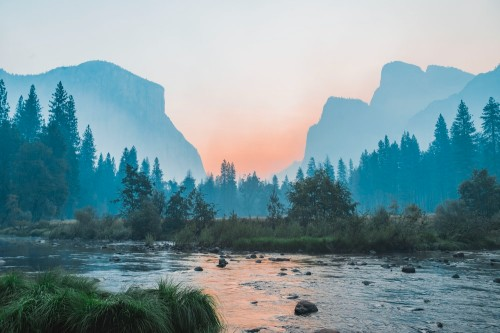

In [100]:
# show the image
mount

# Color Quantization

This image of a mountain landscape is rich and beautiful. But say we're trying to save memory, or simplify the picture, and use fewer distinct colors.

Color Quantization "is a process that reduces the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image."

In other words, we're trying to reduce the # of colors used, while still preserving the general form of the image.

## Simple K-Means Clustering of Pixels
Now that you can see the beautiful mountain image, let's use *clustering* to cluster the pixels from this image according to their color. The Red, Green and Blue values (R, G, and B) are all on the same scale (0-255), **so there is no need to z score**.

The R, G, and B are the features we are going to cluster on. You can think of color in terms of the amount (0-255) of Red, Green, and Blue, and envision a 3D plot of all possible colors.

<img src = "https://drive.google.com/uc?export=view&id=13AS1p5D2SMhD8LLiUTNZDzEKPQMyPU92" alt="Q" style="width: 500px;"/>


We want to cluster similar colors together so that our image is simpler, but still close to the original. First, let's try with a super simple K-Means Cluster.

The dataframe `mount_df` contains all the pixel colors from our mountain image.

1. Create a k-means model with k = 10, and store it in the variable `km`
2. Fit the k-means model on the `mount_df` dataframe
3. Run the following cells to see the new image with clustered colors

In [125]:
### YOUR CODE HERE ################################

# 1. create a K-Means Model
k = 25
km = KMeans(n_clusters=k, n_init=10, random_state=42)

# 2. fit K-Means Model to Pixel Data Frame, mount_df[feats]
km.fit(mount_df[feats])

### /YOUR CODE HERE ###############################

KMeans(n_clusters=25, n_init=10, random_state=42)

### Run these Cells after Running K-Means to see how the image colors were simplified

In [126]:
# grab the cluster assignment for each data point
cluster = km.labels_

# grab the cluster centers, these will be the colors we use
centers = km.cluster_centers_
centers = np.round(centers) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers = [tuple(map(int, c)) for c in centers]

In [127]:
# record which cluster each pixel is in
mount_df["cluster"] = cluster

# grab the cluster center (the NEW color) for that pixel
mount_df["color_tuple"] = [centers[i] for i in mount_df["cluster"]]

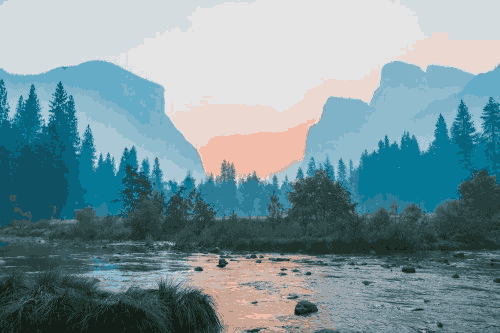

In [128]:
# Turn these new colors into an image so you can plot it
mount_new_list = list(mount_df["color_tuple"])
mount_new = Image.new(mount.mode,mount.size)
mount_new.putdata(mount_new_list)

# show the NEW simpler image
mount_new

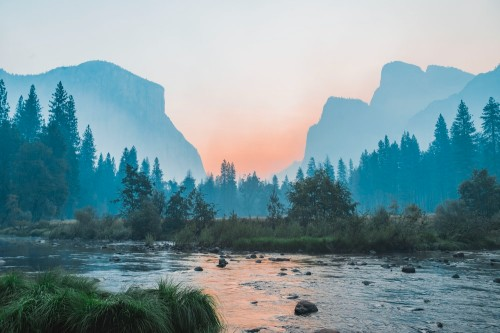

In [129]:
# show the original image
mount

### Question
- Compare the Original and Simpler/New image. What do you notice about how K-Means clustered those colors?
  - The K-Means image looks flatter and uses fewer colors. It grouped similar shades together, so smooth areas like the sky or water look more solid, and the trees lost some detail. It still keeps the overall shape and lighting but looks more cartoon-like.

- If you change k to be something larger, like 25, what changes about the image?
  - The image keeps more color detail and looks closer to the original. The transitions between colors are smoother, and you can see more variation in the sky and trees. It looks less blocky but still slightly simplified.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>

## DBSCAN Clustering of Pixels

Now, let's compare the K-Means clustering of the colors in that image with the DBSCAN clusters. Remember, DBSCAN doesn't require us to specify the number of clusters in advance.

1. Create a DBSCAN model using the `min_samples` and `eps` and store it in the variable `db`
2. Fit the DBSCAB model on the `mount_df` dataframe (this may take a few minutes to run)
3. Run the following cells to see the new image with clustered colors


In [106]:
### YOUR CODE HERE ################################
mins = 10
eps = 2

# build your DBSCAN model with min_samples = mins, and eps = whatever you found, call your step "model"
model = DBSCAN(eps = eps, min_samples = mins)
pipe = Pipeline([("model", model)])

# fit your model  with mount_df[feats]'s RGB columns
db = pipe.named_steps["model"].fit(mount_df[feats])

### /YOUR CODE HERE ###############################

 ### Run these Cells after Running DBSCAN to see how the image colors were simplified


In [107]:
# grab the cluster assignment for each data point
cluster_db = db.labels_

# grab the mean color for each cluster
centers_db = [list(mount_df.loc[cluster_db == c,["R","G","B"]].mean()) for c in set(db.labels_)]
centers_db = np.round(centers_db) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers_db = [tuple(map(int, c)) for c in centers_db]

In [108]:
# record which cluster each pixel is in
mount_df["cluster_db"] = cluster_db

# grab the cluster center (the NEW color) for that pixel
mount_df["color_tuple_db"] = [centers_db[i] for i in mount_df["cluster_db"]]

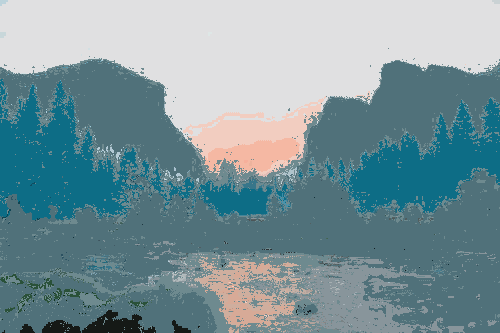

In [109]:
# Turn these new colors into an image so you can plot it
mount_new_list = list(mount_df["color_tuple_db"])
mount_new = Image.new(mount.mode,mount.size)
mount_new.putdata(mount_new_list)

# show the NEW simpler image
mount_new

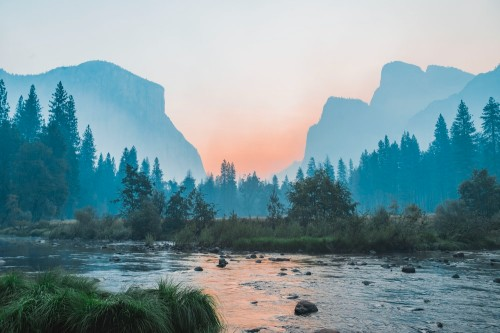

In [110]:
# show the original image
mount

## Reflection

- Use ggplot to make a scatterplot of the `R` and `G` columns of `mount_df` (set alpha to 0.01).

- Use ggplot to make another scatterplot of the `R` and `B` columns of `mount_df` (set alpha to 0.01).

- Use ggplot to make a scatterplot of the `B` and `G` columns of `mount_df` (set alpha to 0.01).

(We make 3 graphs since we can't plot in 3D here).

### Question
- Look at the shapes, spread, and patterns in the data. Why do you see that's interesting? What do the patterns tell you about why DBSCAN performed the way it did (remember the benefits/disadvantages of DBSCAN we discussed in the lecture)?
  - The plots show that the colors blend smoothly with no clear separations. DBSCAN struggles with that because it looks for dense clusters, so it ends up grouping big color regions together or labeling a lot of points as noise.

- Think about what the parameter `eps` is. Given the large number of data points and how they're spread out, what do you think would happen if `eps` were larger? (you can try this out in your code)? Why?
  - A larger eps would connect more points and merge nearby clusters, giving fewer, bigger color groups. The image would look smoother but might lose detail or mix colors that shouldn’t be grouped.

- Also, we treated the "Noise" cluster (if it exists) as it's own cluster. Do you think this is a good idea? What else could we do with the noise cluster?
  - It’s fine for visualization, but it’s not really a true cluster. We could instead assign those noise points to their nearest color cluster so the image looks more continuous.


<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>


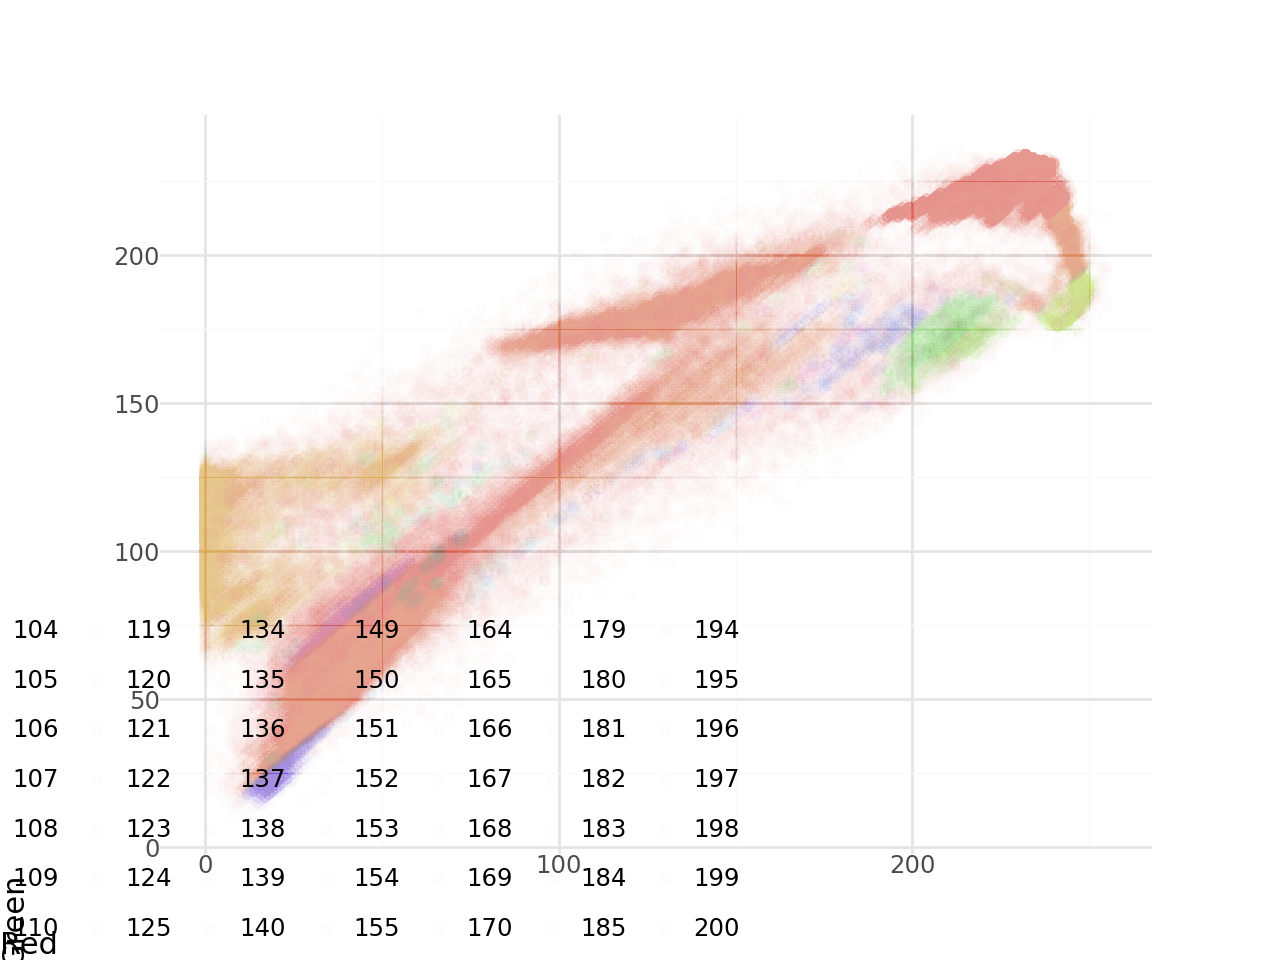

In [111]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "R", y = "G", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "R vs G - DBSCAN Clusters", x="Red", y="Green"))

### /YOUR CODE HERE ################################


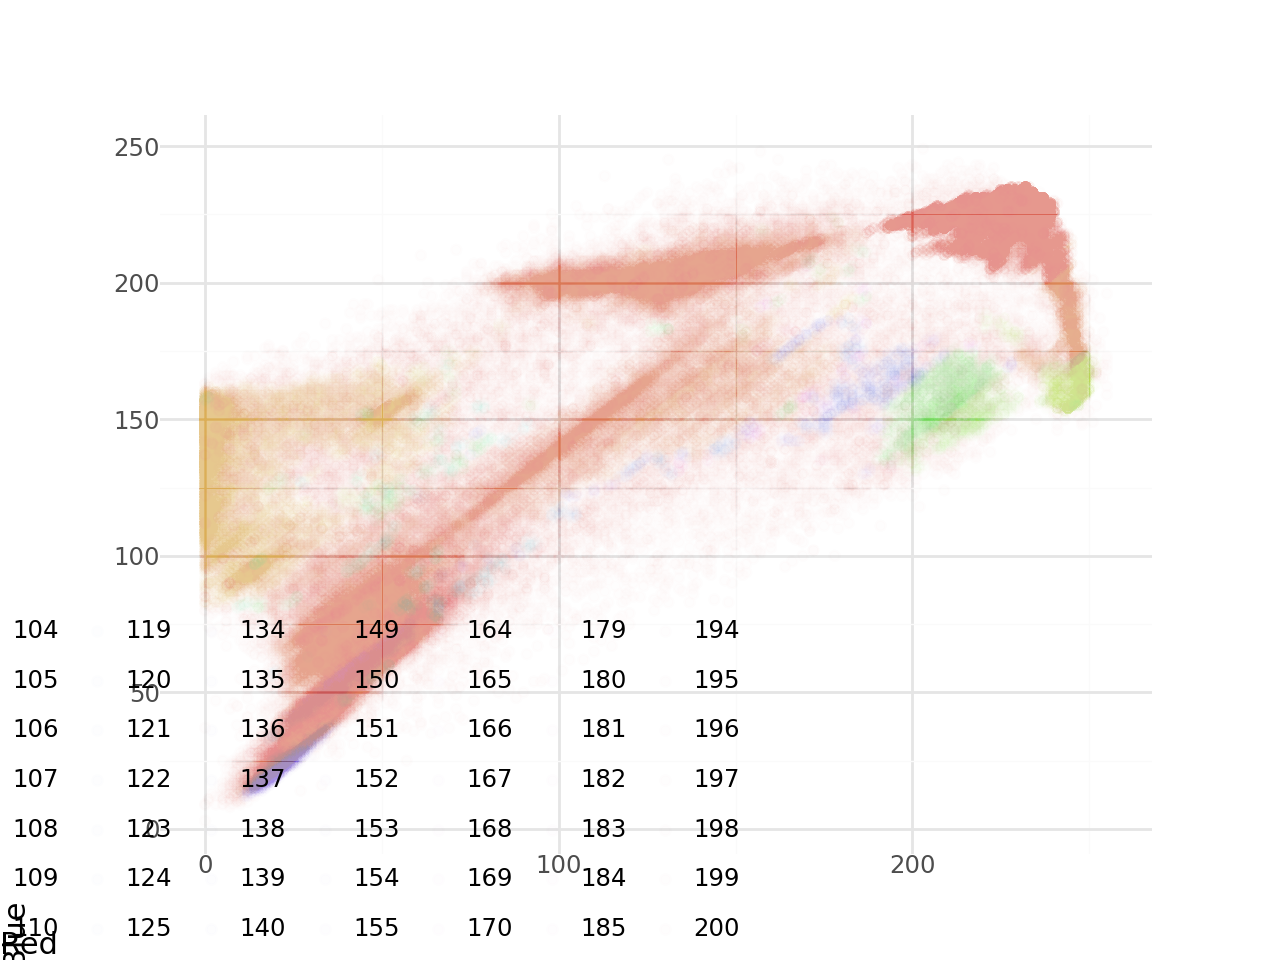

In [112]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "R", y = "B", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "R vs B - DBSCAN Clusters", x="Red", y="Blue"))

### /YOUR CODE HERE ################################


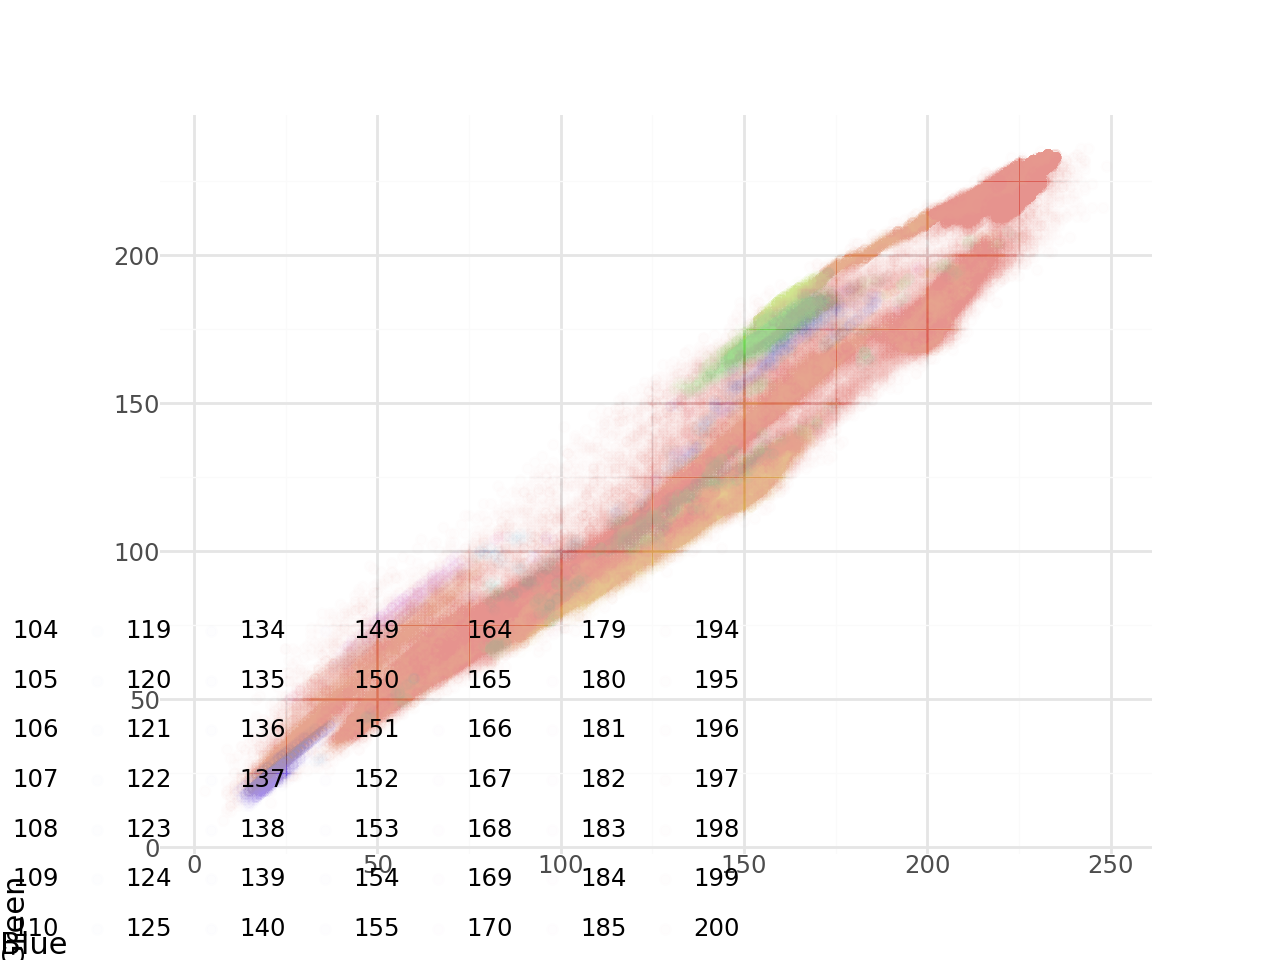

In [93]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "B", y = "G", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "B vs G - DBSCAN Clusters", x="Blue", y="Green"))

### /YOUR CODE HERE ################################


## DBSCAN Clustering of Pixels (NOW WITH MORE CONTRAST)

The last image had a wide range of colors that sort of blended together. Let's see how DBSCAN does with an image with higher contrast.

1. Using a `min_samples` value of 5, build a k-dist graph like we did in the lecture to choose the best value for `eps`
2. Create a DBSCAN model using the `min_samples` and `eps` valuse from above, and store it in the variable `db`
3. Fit the DBSCAB model on the `john_df` dataframe (this may take a few minutes to run)
4. Run the following cells to see the new image with clustered colors


## Download Image
Download the  [chrome](https://github.com/ywen2021/CPSC392/blob/main/Data/chrome.jpg) images from github and store them somewhere convenient on your computer, like your desktop, or CPSC 392 folder.

Upload it to colab using the Folder Icon on the left.

In [113]:
# open the image

### ADD YOUR IMAGE NAME AS THE FIRST ARGUMENT
john = Image.open("chrome.jpg",'r')

# grab the image size
width, height = john.size

# turn the image into a data frame of all the pixels
# with RBG columns
pixels = list(john.getdata())

R = [i[0] for i in pixels]
G = [i[1] for i in pixels]
B = [i[2] for i in pixels]

john_df = pd.DataFrame({"R": R,
                        "G": G,
                        "B": B})

print("The width/height of this image is: ", width, " by ", height, " pixels")

john_df.head()

The width/height of this image is:  180  by  168  pixels


R    G    B
0  228  228  228
1  228  228  228
2  228  228  228
3  228  228  228
4  228  228  228

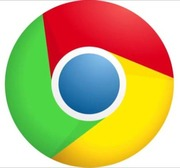

In [114]:
john

In [115]:
### YOUR CODE HERE ################################
mins = 2

# create Nearest Neighbors model pipeline, and fit it
nn = NearestNeighbors(n_neighbors = mins + 1)
pipe_elbow = Pipeline([("nn", nn)])

# fit nn model
pipe_elbow.fit(john_df[feats])

# sort the distances
distances, neighbors = pipe_elbow.named_steps["nn"].kneighbors(john_df[feats])
distances = np.sort(distances[:, mins], axis = 0)

### /YOUR CODE HERE ################################


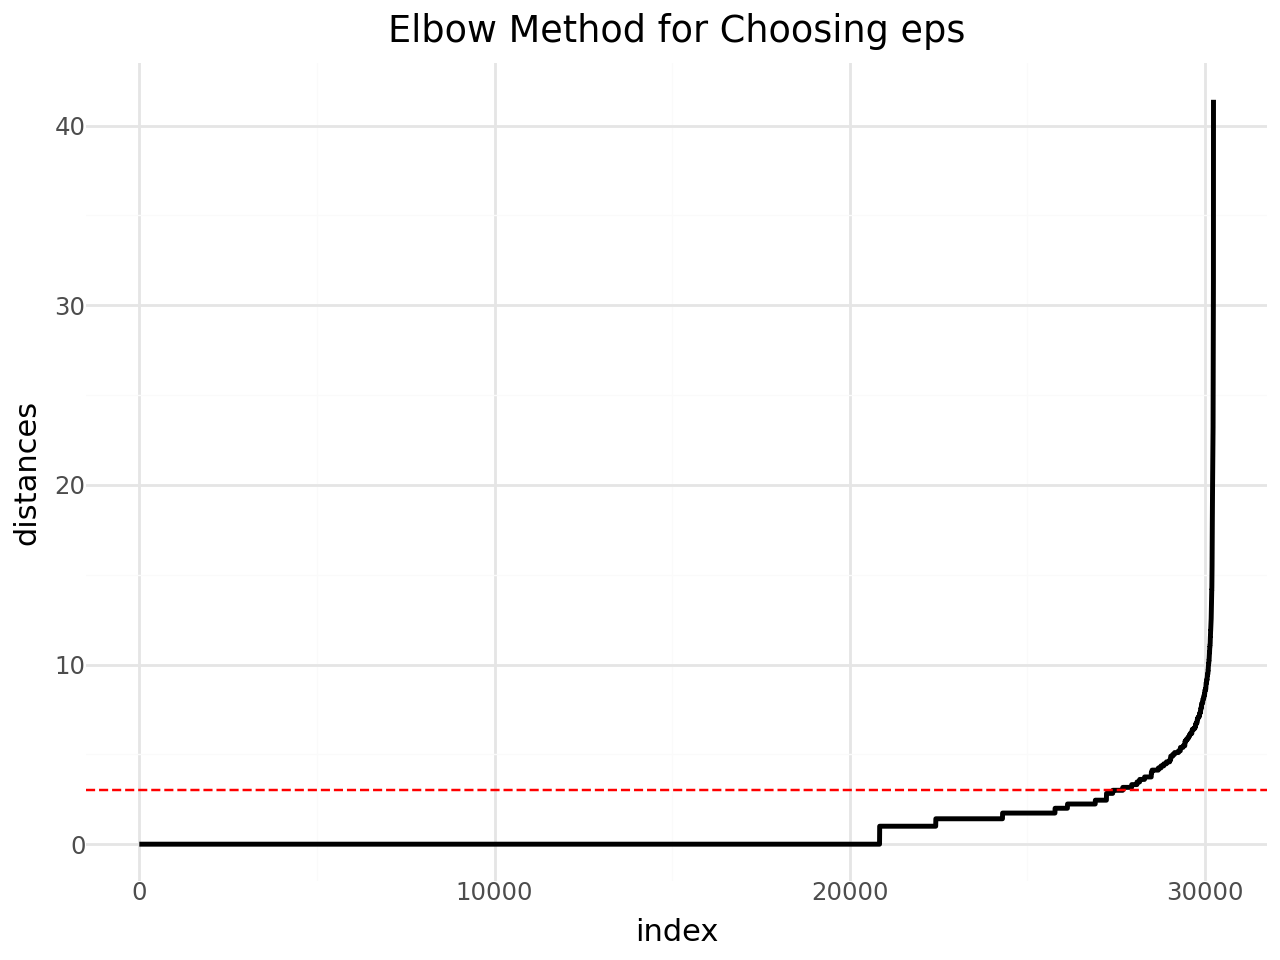

In [116]:
### YOUR CODE HERE ################################
distances_df = pd.DataFrame({"distances": distances,
                            "index": list(range(0, len(distances)))})

#plot the distances
(ggplot(distances_df, aes(x = "index", y = "distances")) +
    geom_line(size = 1) + theme_minimal() +
    geom_hline(yintercept = 3, color = "red", linetype = "dashed") +
    labs(title = "Elbow Method for Choosing eps"))

### /YOUR CODE HERE ################################


In [117]:
### YOUR CODE HERE ################################
mins = 10
eps = 3

# build your DBSCAN model with min_samples = 10, and eps = whatever you found
db_john = DBSCAN(eps = eps, min_samples = mins)
pipe = Pipeline([("model", db_john)])

# fit your model with mount_df's RGB columns
db = pipe.named_steps["model"].fit(john_df[feats])

### /YOUR CODE HERE ###############################

 ### Run these Cells after Running DBSCAN to see how the image colors were simplified


In [118]:
# grab the cluster assignment for each data point
cluster_db_john  = db_john.labels_

# grab the mean color for each cluster
centers_db_john = [list(john_df.loc[cluster_db_john == c,["R","G","B"]].mean()) for c in set(db_john.labels_)]
centers_db_john = np.round(centers_db_john) # round the numbers to be integers

# turn the RGB values into a tuple, (R,G,B) so that it will work with PIL package
centers_db_john = [tuple(map(int, c)) for c in centers_db_john]

In [119]:
# record which cluster each pixel is in
john_df["cluster_db"] = cluster_db_john

# grab the cluster center (the NEW color) for that pixel
john_df["color_tuple_db"] = [centers_db_john [i] for i in john_df["cluster_db"]]

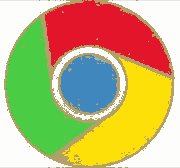

In [120]:
# Turn these new colors into an image so you can plot it
john_new_list = list(john_df["color_tuple_db"])
john_new = Image.new(john.mode,john.size)
john_new.putdata(john_new_list)

# show the NEW simpler image
john_new

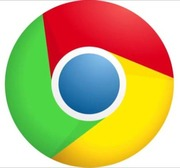

In [121]:
# show the original image
john

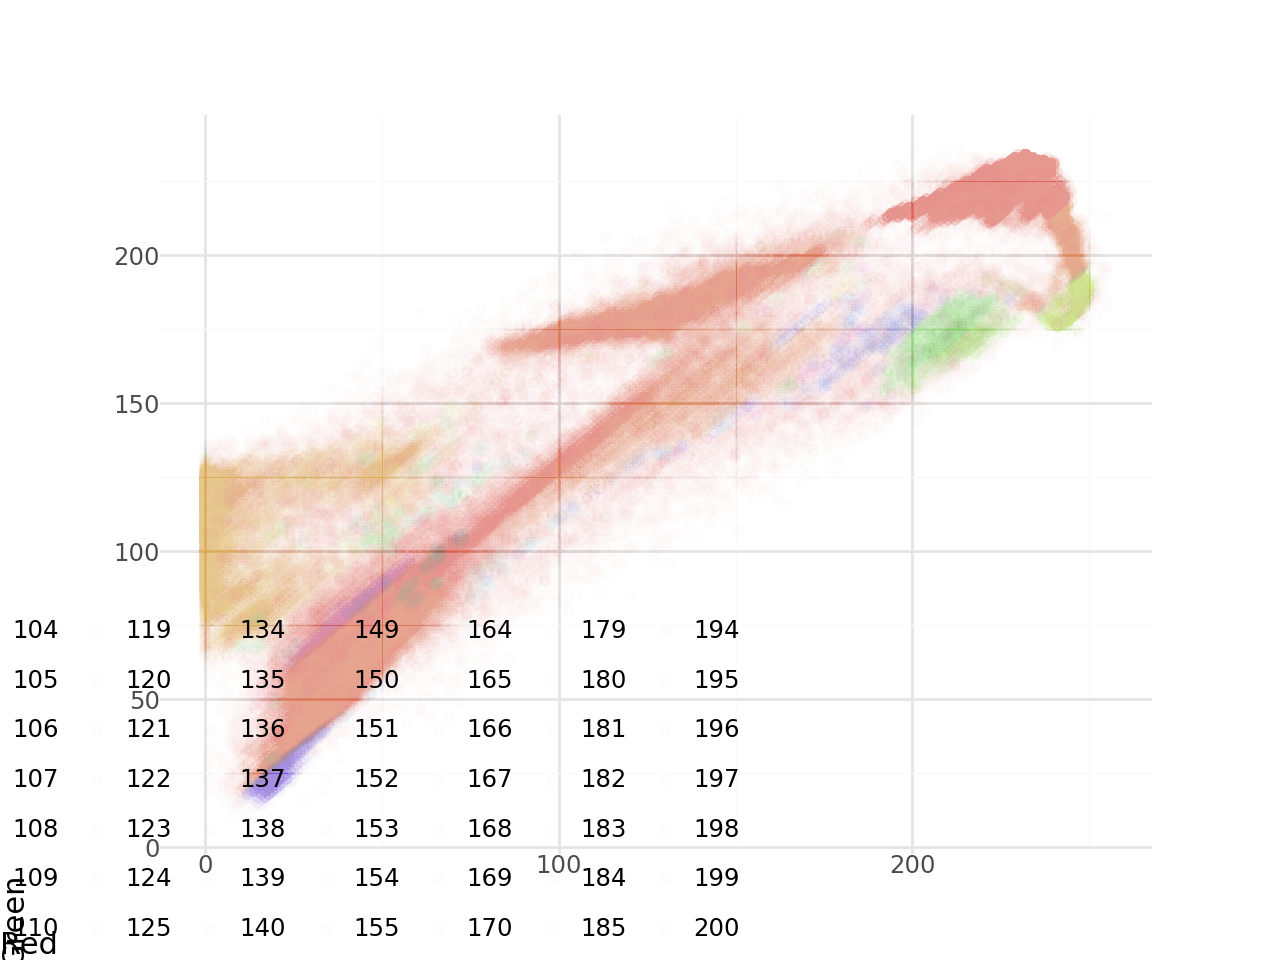

In [122]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "R", y = "G", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "R vs G - DBSCAN Clusters", x="Red", y="Green"))

### /YOUR CODE HERE ################################


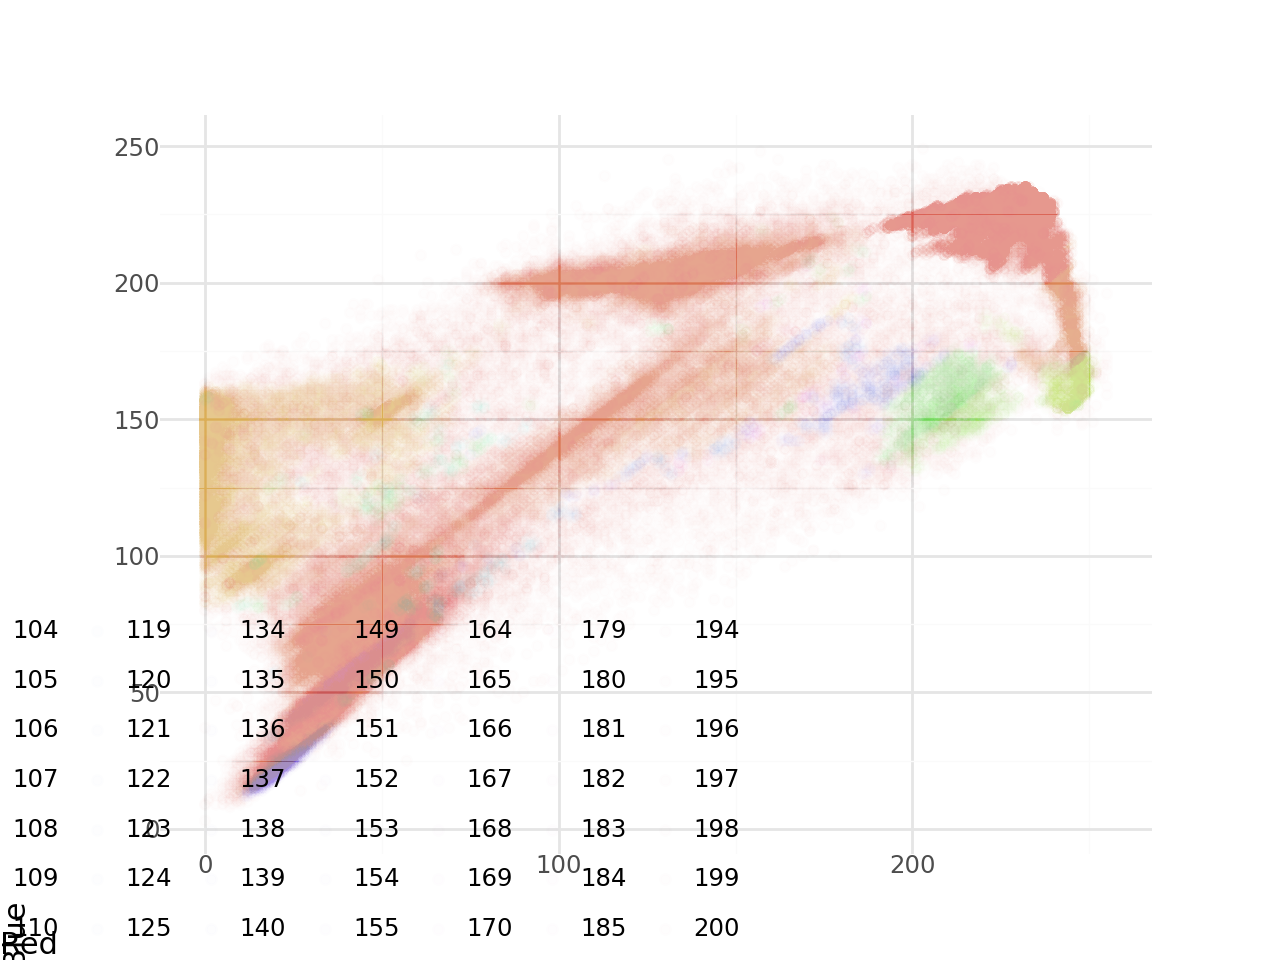

In [123]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "R", y = "B", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "R vs B - DBSCAN Clusters", x="Red", y="Blue"))

### /YOUR CODE HERE ################################


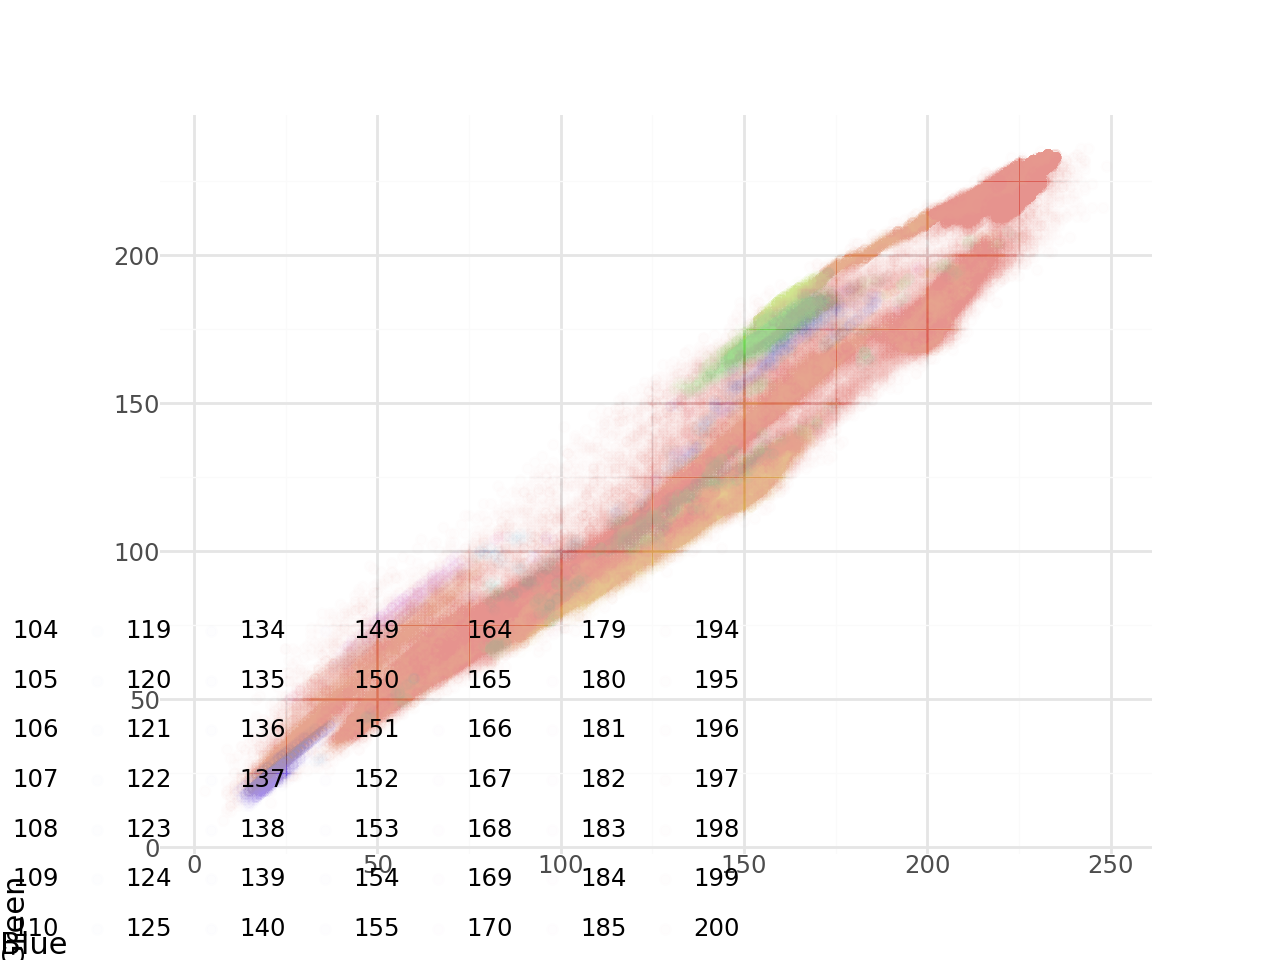

In [124]:
### YOUR CODE HERE ################################
(ggplot(mount_df, aes(x = "B", y = "G", color = "factor(cluster_db)")) +
    geom_point(alpha=0.01) + theme_minimal() +
    labs(title = "B vs G - DBSCAN Clusters", x="Blue", y="Green"))

### /YOUR CODE HERE ################################


### Question
- Look at the shapes, spread, and patterns in the data. Why do you see that's interesting? What do the patterns tell you about why DBSCAN performed the way it did (remember the benefits/disadvantages of DBSCAN we discussed in the lecture)?
  - The plots show clear, dense color groups with sharp boundaries between them. That’s why DBSCAN was able to separate each main color area easily, it can detect the distinct red, yellow, green, and blue sections since the color values don’t blend much.

- Based on what you know about DBSCAN, why do you think it worked *better* in this image, than in the image of mountains?
  - This image has high contrast and very defined color regions, which fit how DBSCAN finds clusters. The mountain image had lots of smooth color gradients, so DBSCAN couldn’t find clear borders and ended up with more noise.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" style="width: 200px;"/>
